# Siamese

Source: https://keras.io/examples/mnist_siamese/

In [1]:
import numpy as np

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K

import h5py
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops

In [2]:
EPOCHS = 10
BATCH_SIZE = 256
ACCURACY_THRESHOLD = 1e-4

In [3]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [4]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    return  K.mean(K.square(y_pred - y_true))

def create_pairs(x, y, pairs_num):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    # TODO: make half half (far and close ones)
    # kNN same as before
    pairs = []
    labels = []
    
    for i in range(pairs_num):
        z1 = np.random.randint(0, len(x)) #, pairs_num)
        z2 = np.random.randint(0, len(x)) #, pairs_num)
        pairs += [[x[z1], x[z2]]]

        labels += [d_q(euler2quaternion(y[z1]), euler2quaternion(y[z2]))]

    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    print(input_x)
    
    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(256, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    print(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)
    
    x = Conv2D(1, [1, 1], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    print(x)

    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)
    print(x)
    #x = Flatten()(x)
    
    return Model(input_x, x)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_pred = K.flatten(y_pred)

    return K.mean(K.square(y_pred - y_true) < ACCURACY_THRESHOLD)

gloabal average pooling - width and hights OR 
flatten

Pooling - shrinks in space

In [5]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    y_pred = K.flatten(y_pred)

    return K.mean(K.square(y_pred - y_true) < ACCURACY_THRESHOLD)

In [6]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
n_samples = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{n_samples}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

In [7]:
# the data, split between train and test sets
X, y = data['Projections'], data['Angles']
X.shape, y.shape

((5000, 116, 116), (5000, 3))

In [8]:
train_idx, test_idx, _, _ = train_test_split(range(len(X)), range(len(y)), test_size=0.33, random_state=42)
train_idx = sorted(train_idx)
test_idx = sorted(test_idx)

In [9]:
X_train, y_train = X[train_idx], y[train_idx]
X_test, y_test = X[test_idx], y[test_idx]

In [10]:
tr_pairs, tr_y = create_pairs(X_train, y_train, 5000)
#print(tr_pairs.shape)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
#tr_pairs = tr_pairs.reshape([tr_pairs.shape[0], tr_pairs.shape[1], 1, tr_pairs.shape[2], tr_pairs.shape[3]])
#tr_y = tr_y.reshape(list(tr_y.shape) + [-1])
#print(tr_y.shape)
#tr_y = tr_y.reshape([-1] + list(tr_y.shape))
tr_y = tf.cast(tr_y, dtype=tf.float32)

(5000, 2, 116, 116)
(5000,)


In [11]:
te_pairs, te_y = create_pairs(X_test, y_test, 1000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
#te_pairs = te_pairs.reshape([te_pairs.shape[0], te_pairs.shape[1], 1, te_pairs.shape[2], te_pairs.shape[3]])
#te_y = te_y.reshape(list(te_y.shape) + [-1])
#te_y = te_y.reshape([-1] + list(te_y.shape))
te_y = tf.cast(te_y, dtype=tf.float32)

In [12]:
input_shape = list(te_pairs[:, 0].shape[1:])
print(f"Input images shape {input_shape}")

Input images shape [116, 116, 1]


In [13]:
X_train.shape

(3350, 116, 116)

In [14]:
tr_pairs.shape

(5000, 2, 116, 116, 1)

In [15]:
te_pairs[:, 0].shape

(1000, 116, 116, 1)

In [16]:
te_y.shape

TensorShape([1000])

---

0.15 loss, 0.0017 acc

test set
plot train and test losses

In [17]:
# network definition
base_network = create_base_network(input_shape)


input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)



# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)



distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])


model = Model([input_a, input_b], distance)


# train
rms = RMSprop()


model.compile(loss=loss, optimizer=rms, metrics=None)  #[accuracy])


model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))



Tensor("input_1:0", shape=(None, 116, 116, 1), dtype=float32)
Tensor("conv2d/Identity:0", shape=(None, 116, 116, 32), dtype=float32)
Tensor("max_pooling2d/Identity:0", shape=(None, 58, 58, 32), dtype=float32)
Tensor("conv2d_1/Identity:0", shape=(None, 58, 58, 64), dtype=float32)
Tensor("max_pooling2d_1/Identity:0", shape=(None, 29, 29, 64), dtype=float32)
Tensor("conv2d_2/Identity:0", shape=(None, 29, 29, 128), dtype=float32)
Tensor("max_pooling2d_2/Identity:0", shape=(None, 15, 15, 128), dtype=float32)
Tensor("conv2d_3/Identity:0", shape=(None, 15, 15, 256), dtype=float32)
Tensor("max_pooling2d_3/Identity:0", shape=(None, 8, 8, 256), dtype=float32)
Tensor("max_pooling2d_4/Identity:0", shape=(None, 4, 4, 1), dtype=float32)
Tensor("average_pooling2d/Identity:0", shape=(None, 1, 1, 1), dtype=float32)
Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 17s 3ms/sample - loss: 2.4080 - val_loss: 1.8486
Epoch 2/10
5000/5000 [===============

In [19]:
# compute final accuracy on training and test sets
y_tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_tr_pred)
print(f'* Accuracy on training set: {(100 * tr_acc):.2f}%')

* Accuracy on training set: 0.56%


In [ ]:
tr_pairs[:, 0].shape, tr_y.shape, y_pred.shape

In [20]:
y_te_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_te_pred)
print(f'* Accuracy on test set: {(100 * te_acc):.2f}%')

* Accuracy on test set: 0.70%


In [ ]:
te_pairs.shape

In [25]:
te_pairs = te_pairs.reshape(list(te_pairs.shape[:-2]) +[-1])
te_pairs.shape

(1000, 2, 116, 116)

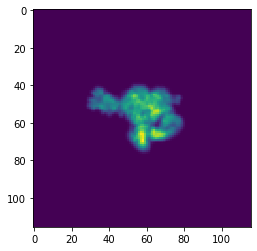

In [26]:
plt.imshow(te_pairs[10, 0])

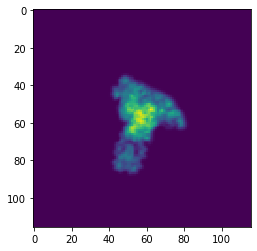

In [27]:
plt.imshow(te_pairs[10, 1])

In [28]:
loss(y_te_pred[0], te_y[0].numpy())

<tf.Tensor: id=584737, shape=(), dtype=float32, numpy=1.7773831>

In [29]:
y_te_pred[0], te_y[0].numpy()

(array([[[0.369761]]], dtype=float32), 1.7029463)

In [21]:
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape[:-2]) +[-1])
tr_pairs.shape

(5000, 2, 116, 116)

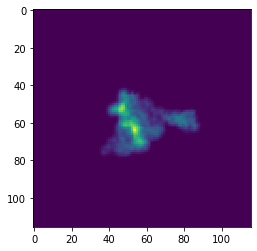

In [22]:
plt.imshow(tr_pairs[10, 0])

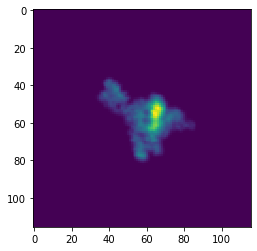

In [23]:
plt.imshow(tr_pairs[10, 1])

In [24]:
loss(y_tr_pred[0], tr_y[0].numpy())

<tf.Tensor: id=584729, shape=(), dtype=float32, numpy=6.347074>

In [30]:
y_tr_pred[0], tr_y[0].numpy()

(array([[[0.58189464]]], dtype=float32), 3.1012347)